In [2]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def algo_simulator(budget:int,workers_power:int,quality:float,noise:float):
    runs=[]
    for i in range((2**workers_power)):
        runs.append([1])
    prev_workers=2**workers_power
    for i in range(1,budget):
        multiplier=budget/(i+1)
        current_workers=2**min(np.floor(np.log2(multiplier)),workers_power)
        runs= sorted(runs, key=lambda x: x[-1])
        if current_workers!=prev_workers:
            for worker in range(int(current_workers)):
                new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
                runs[worker].append(min([runs[worker][-1],new_point]))
        prev_workers=current_workers
    return runs

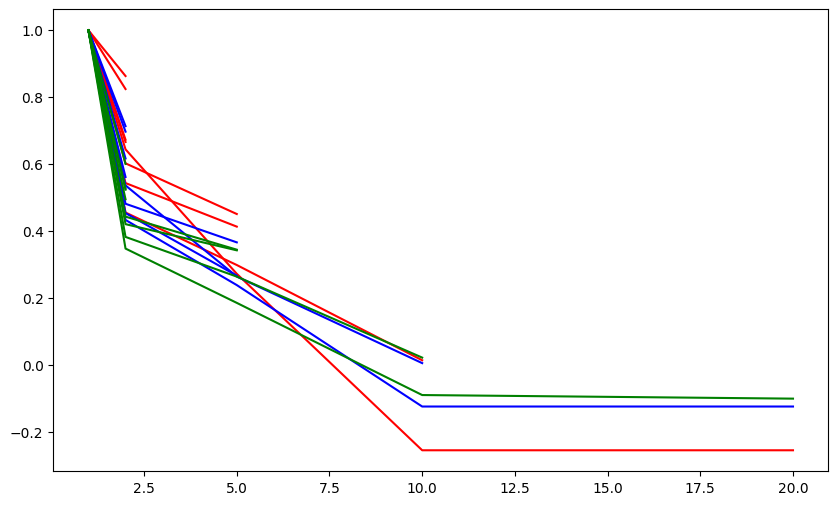

In [4]:
max_budget=20
number_of_workers_power=4
quality=[0.5,0.6,0.8]
colors=["red","blue","green"]
noise=0.1

runs=[]
y_data=[]
algo_numbers=[]
for algo_number in range(len(quality)):
    run=algo_simulator(budget=max_budget,workers_power=number_of_workers_power,quality=quality[algo_number],noise=noise)
    runs+=run
    algo_numbers+=list(np.ones(shape=len(run),dtype=int)*algo_number)

for run in runs:
    y_data.append([])
    for i in range(0,len(run)):
        y_data[-1].append(int((2**i/2**number_of_workers_power)*max_budget))



_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(runs):
    axis.errorbar(
        y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

In [5]:
saved_runs=runs
saved_y_data=y_data
saved_algo_numbers=algo_numbers


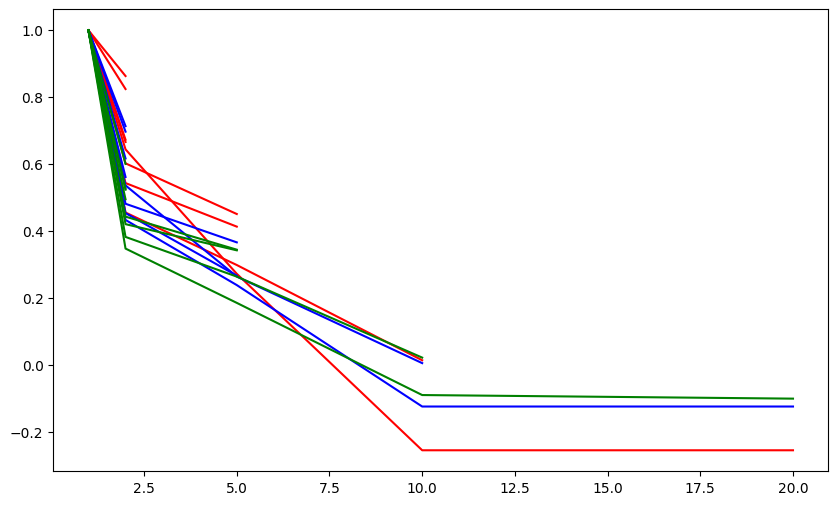

In [6]:
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)


_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(saved_runs):
    axis.errorbar(
        saved_y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

df=pd.DataFrame(columns=["score","budget","algo","rng"])
for run_number,run in enumerate(saved_runs):
    for data_number,datapoint in enumerate(run):
        df.loc[len(df)] =[datapoint,saved_y_data[run_number][data_number],str(saved_algo_numbers[run_number]),str(random.randint(0,2))]


#conduct_analysis(df,"score","algo","rng")

In [7]:
from pymer4 import Lmer

metric="score"
system_id="algo"
input_id="rng"
random_effect="budget"

no_random_effect_model = Lmer(
    formula=f"{metric}~{system_id}+(1|{input_id})", data=df
)
# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
no_random_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(no_random_effect_model.summary())
print("Ranef:")
print(no_random_effect_model.ranef)
print()



fixed_effect_model = Lmer(
    formula=f"{metric}~{system_id}+(1|{random_effect})+(1|{input_id})", data=df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
fixed_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(fixed_effect_model.summary())
print("Ranef:")
print(fixed_effect_model.ranef)
print()


post_hoc_results2 = no_random_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results2)


post_hoc_results3 = fixed_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results3)






boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: score~algo+(1|rng)

Family: gaussian	 Inference: parametric

Number of observations: 93	 Groups: {'rng': 3.0}

Log-likelihood: -40.010 	 AIC: 90.021

Random effects:

                 Name    Var    Std
rng       (Intercept)  0.000  0.000
Residual               0.138  0.372

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)     0.717   0.586    0.848  0.067  93.0  10.725  0.000  ***
algo1          -0.027  -0.212    0.159  0.095  93.0  -0.281  0.779     
algo2          -0.048  -0.234    0.137  0.095  93.0  -0.513  0.609     
Ranef:
   X.Intercept.
0           0.0
1           0.0
2           0.0

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: score~algo+(1|budget)+(1|rng)

Family: gaussian	 Inference: parametric

N

In [32]:
def algo_simulator2(budget:int,workers_power:int,quality:float,noise:float):
    runs=[]
    for i in range((2**workers_power)):
        runs.append([1])
    prev_workers=2**workers_power
    for i in range(1,budget):
        multiplier=budget/(i+1)
        current_workers=2**min(np.floor(np.log2(multiplier)),workers_power)
        runs= sorted(runs, key=lambda x: x[-1])
        if current_workers!=prev_workers:
            for worker in range(int(current_workers)):
                new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
                runs[worker].append(min([runs[worker][-1],new_point]))
        prev_workers=current_workers
    return runs

max_budget=20
number_of_workers_power=4
quality=[0.5,0.6,0.8]
colors=["red","blue","green"]
noise=0.1
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

runs=[]
y_data=[]
algo_numbers=[]
for algo_number in range(len(quality)):
    run=algo_simulator2(budget=max_budget,workers_power=number_of_workers_power,quality=quality[algo_number],noise=noise)
    runs+=run
    algo_numbers+=list(np.ones(shape=len(run),dtype=int)*algo_number)

for run in runs:
    y_data.append([])
    for i in range(0,len(run)):
        y_data[-1].append(int((2**i/2**number_of_workers_power)*max_budget))




saved_runs=runs
saved_y_data=y_data
saved_algo_numbers=algo_numbers

df=pd.DataFrame(columns=["score","budget","algo","rng"])
for run_number,run in enumerate(saved_runs):
    for data_number,datapoint in enumerate(run):
        df.loc[len(df)] =[datapoint,saved_y_data[run_number][data_number],str(saved_algo_numbers[run_number]),str(random.randint(0,2))]
repeated_df=pd.DataFrame(columns=["score","budget","algo","rng"])
for budget in df["budget"].unique():
    #print(budget)
    df_budget=df.loc[df["budget"]==budget]
    #print(number_of_workers_power-min(np.floor(np.log2(max_budget/(budget))),number_of_workers_power)+1)
    #print(np.repeat(df_budget.values,number_of_workers_power-min(np.floor(np.log2(max_budget/(budget))),number_of_workers_power)+1,axis=0))
    repeated_df=pd.concat([repeated_df,pd.DataFrame(np.repeat(df_budget.values,2**(number_of_workers_power-min(np.floor(np.log2(max_budget/(budget))),number_of_workers_power)+1)-1,axis=0),columns=["score","budget","algo","rng"])],ignore_index=True)
#print(repeated_df)
repeated_df["score"]=repeated_df["score"].apply(float)

fixed_effect_model = Lmer(
    formula=f"{metric}~{system_id}+(1|{random_effect})+(1|{input_id})", data=repeated_df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
fixed_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(fixed_effect_model.summary())
print("Ranef:")
print(fixed_effect_model.ranef)
print()


post_hoc_results3 = fixed_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results3)

        score budget algo rng
0         1.0      1    0   0
1         1.0      1    0   0
2         1.0      1    0   2
3         1.0      1    0   1
4         1.0      1    0   1
5         1.0      1    0   0
6         1.0      1    0   0
7         1.0      1    0   2
8         1.0      1    0   0
9         1.0      1    0   1
10        1.0      1    0   1
11        1.0      1    0   1
12        1.0      1    0   2
13        1.0      1    0   1
14        1.0      1    0   1
15        1.0      1    0   0
16        1.0      1    1   1
17        1.0      1    1   1
18        1.0      1    1   2
19        1.0      1    1   1
20        1.0      1    1   0
21        1.0      1    1   1
22        1.0      1    1   2
23        1.0      1    1   2
24        1.0      1    1   1
25        1.0      1    1   2
26        1.0      1    1   0
27        1.0      1    1   1
28        1.0      1    1   2
29        1.0      1    1   0
30        1.0      1    1   2
31        1.0      1    1   0
32        

c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "score". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '


RRuntimeError: Error in mkRespMod(fr, REML = REMLpass) : response must be numeric
